## Задача 3

### Описание данных

Подсчитываемыми объектами являются клетки мозга на снимках, полученных флуоресцентной микроскопией. Исходные матриалы и архив с данными доступны [на странице датасета в Kaggle](https://www.kaggle.com/datasets/nbroad/fluorescent-neuronal-cells). Для работы кода требуется скачать материалы и поместить .zip архив в одну папку с исходным кодом.

В датасете содержатся исходные изображения и сделанные по ним готовые бинарные маски.

### Постановка задачи

Задачей является самостоятельное построение бинарных масок объектов и сравнение колличества подсчитанных по ним объектов с аналогичными результатами по готовым маскам.

Особенности датасета:
- Объекты расположены довольно разреженно, мала вероятность пересечения
- Объекты не имеют однообразной формы, нет четко выраженной границы
- На изображениях есть лишние блики, не являющиеся объектами, довольно похожи на искомые объекты
- Объекты частично полупрозрачны, при бинаризации возможны внутренние дырки

## Решение задачи

#### Подготовка исходных данных и ответов

In [1]:
from os.path import join
from loader import load_test_res_files
import image_processing
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [2]:


ZIP_FILE_NAME = "archive.zip" # Set your archive name here
TRAIN_DIR = join("all_images", "images")
TEST_DIR = join("all_masks", "masks")

train_pic_files, test_mask_files = load_test_res_files(ZIP_FILE_NAME, TRAIN_DIR, TEST_DIR)

print(train_pic_files[10:12])
print(test_mask_files[10:12])

['archive\\all_images\\images\\Mar19bS1C3R1_VLPAGl_200x_y.png', 'archive\\all_images\\images\\Mar19bS1C3R2_VLPAGl_200x_y.png']
['archive\\all_masks\\masks\\Mar19bS1C3R1_VLPAGl_200x_y.png', 'archive\\all_masks\\masks\\Mar19bS1C3R2_VLPAGl_200x_y.png']


Загружаем изображения как массивы numpy:

In [3]:
train_pics = image_processing.load_images_from_files(train_pic_files)
test_masks = image_processing.load_images_from_files(test_mask_files)

print(train_pics.shape, test_masks.shape)

(283, 1200, 1600, 3) (283, 1200, 1600)


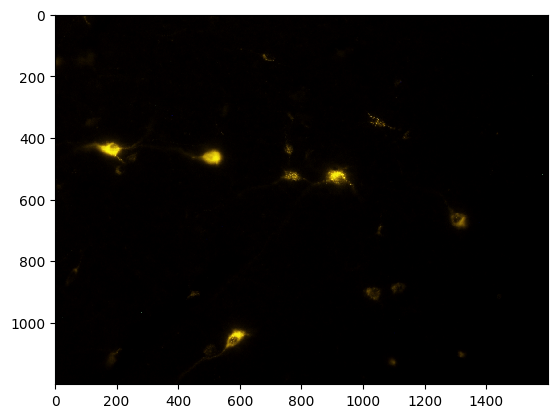

In [4]:
EXAMPLE_ID = 196
image_processing.draw_plt_image(train_pics[EXAMPLE_ID])

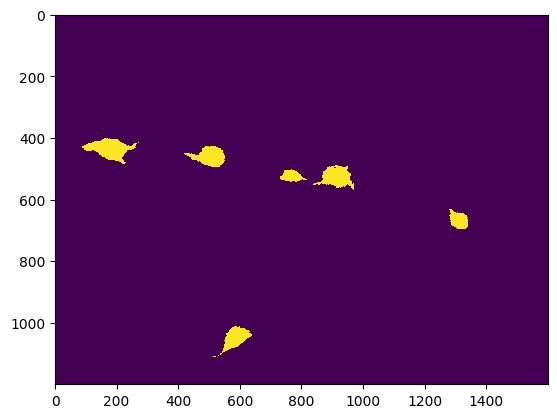

In [5]:
image_processing.draw_plt_image(test_masks[EXAMPLE_ID])

#### Обработка входного изображения

Выберем одно изображение, выполним его обработку, потом проверим на остальных изображениях эту стратегию.

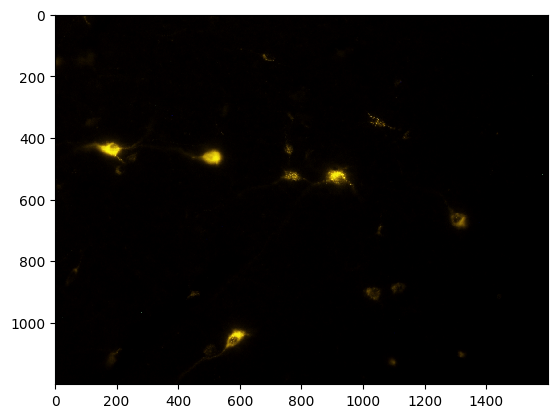

In [6]:
orig_pic = train_pics[EXAMPLE_ID].copy()
image_processing.draw_plt_image(orig_pic)

Приведем изображение к ЧБ:

(1200, 1600) uint8


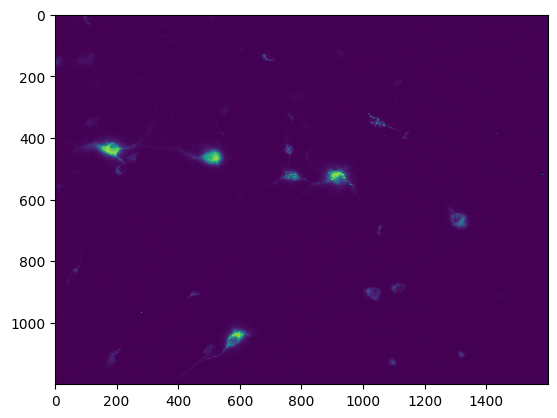

In [7]:
grey_pic = cv.cvtColor(orig_pic, cv.COLOR_BGR2GRAY)
print(grey_pic.shape, grey_pic.dtype)
image_processing.draw_plt_image(grey_pic)

(array([2.81875e+05, 8.61400e+03, 3.44100e+03, 2.20500e+03, 1.46400e+03,
        1.16700e+03, 1.24100e+03, 1.21200e+03, 9.86000e+02, 5.00000e+00]),
 array([  1. ,  21.8,  42.6,  63.4,  84.2, 105. , 125.8, 146.6, 167.4,
        188.2, 209. ]),
 <BarContainer object of 10 artists>)

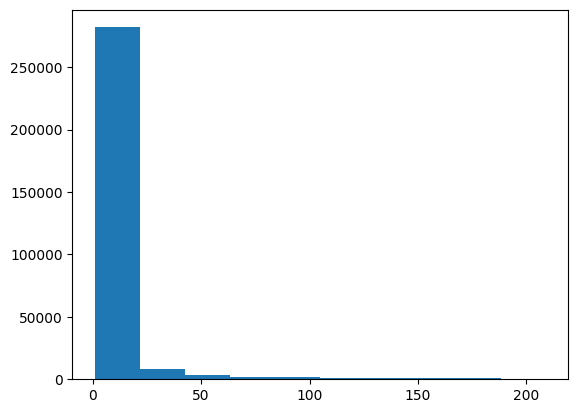

In [8]:
plt.hist(grey_pic.flatten()[grey_pic.flatten() > 0])

Большое количество тусклых пикселей, близких к черному. Попробуем их подрезать:

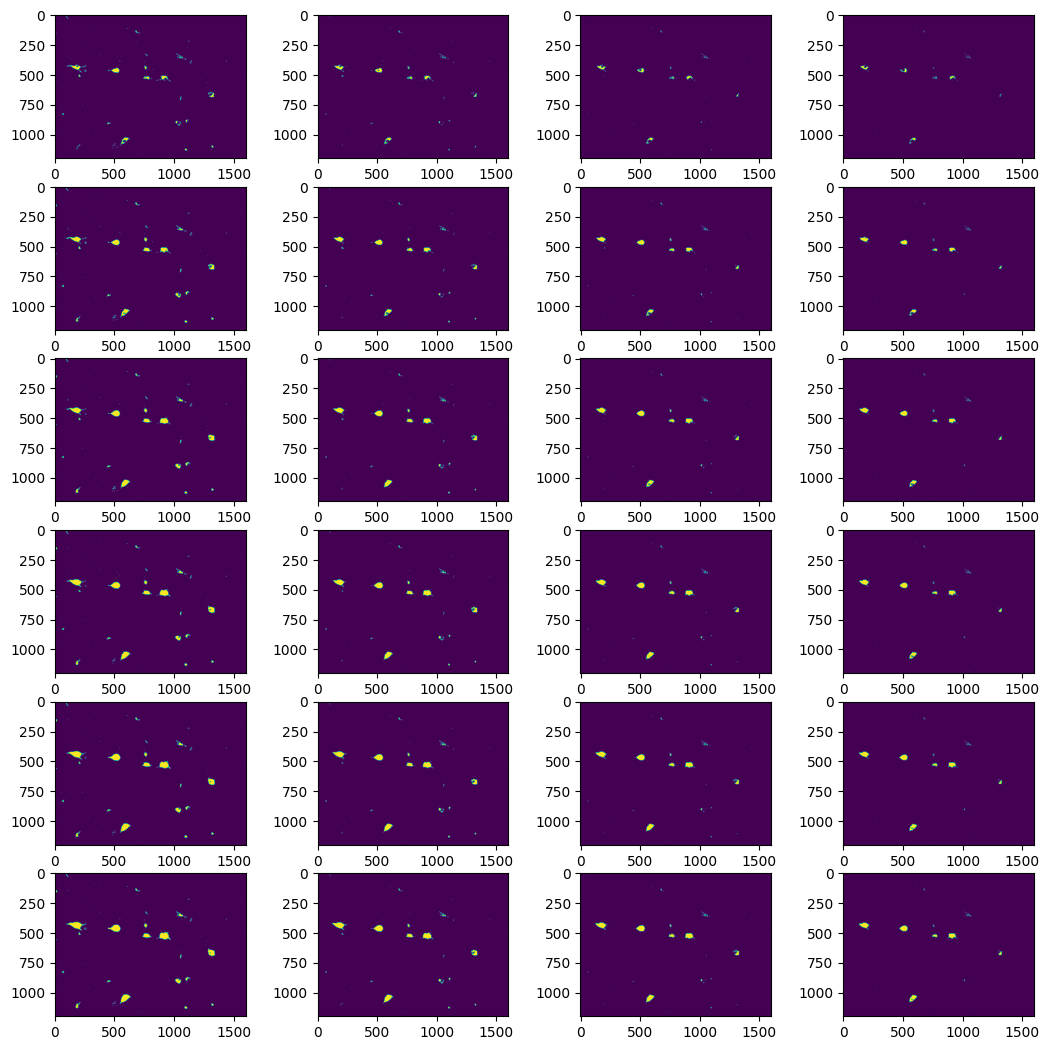

<Figure size 640x480 with 0 Axes>

In [9]:
AREA_SIZE = 6
CONSTANT_SIZE = 4

fig, axs = plt.subplots(AREA_SIZE, CONSTANT_SIZE)
fig.set_figwidth(13)
fig.set_figheight(13)
orig_fig = plt.figure()

for area_mult in range(AREA_SIZE):
    for const_mult in range(CONSTANT_SIZE):
        curr_binarized = cv.adaptiveThreshold(grey_pic, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 40 * (area_mult + 1) + 1, -10 * (const_mult + 1))
        axs[area_mult, const_mult].imshow(curr_binarized)

plt.show()

Лучше всех выглядят параметры 241, -40:

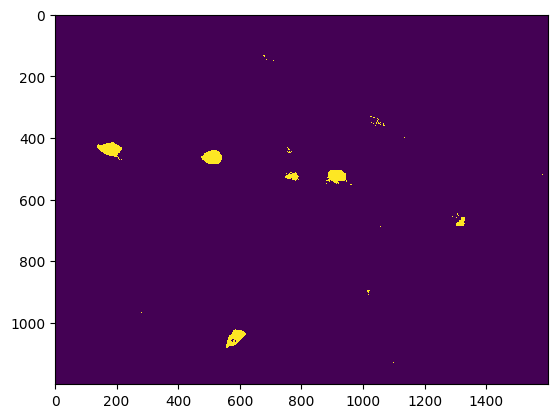

In [10]:
RESULT_AREA = 241
CONSTANT_SUB = -40
binarized = cv.adaptiveThreshold(grey_pic, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, RESULT_AREA, CONSTANT_SUB)
image_processing.draw_plt_image(binarized)

На изображении остается мелкий шум, а некоторые компоненты имеют внутри себя дырки из-за полупрозрачности объектов. Сначала очистим шум, затем нарастим объекты.

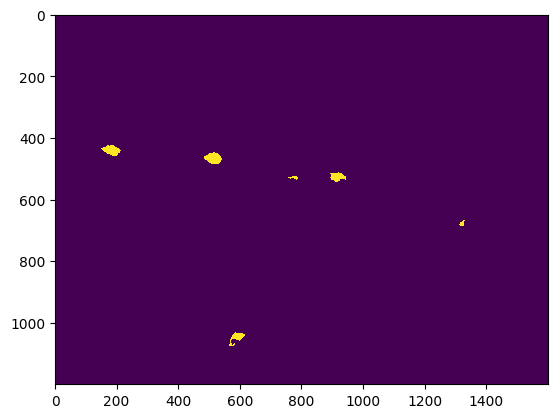

In [11]:
ELLIPSE_SIZE = 2
ERODE_ITS = 9

ellipse_struct = cv.getStructuringElement(cv.MORPH_ELLIPSE, (ELLIPSE_SIZE, ELLIPSE_SIZE))
cleaned_bin = cv.erode(binarized, ellipse_struct, iterations=ERODE_ITS)
image_processing.draw_plt_image(cleaned_bin)

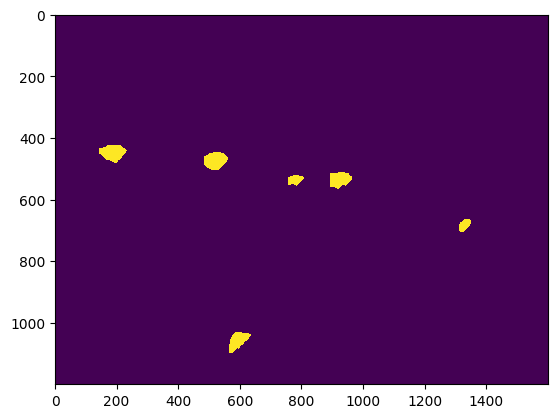

In [12]:
DILATE_ITS = 20
result_bin = cv.dilate(cleaned_bin, ellipse_struct, iterations=DILATE_ITS)
image_processing.draw_plt_image(result_bin)

Сравнение с референсной маской:

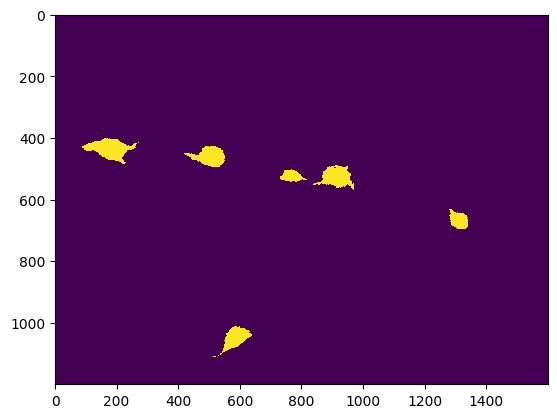

In [13]:
image_processing.draw_plt_image(test_masks[EXAMPLE_ID])

Полученный алгоритм преобразуем в функцию:

In [14]:
def get_bin_component_image(in_image):
    grey_image = cv.cvtColor(in_image, cv.COLOR_BGR2GRAY)
    bin_image = cv.adaptiveThreshold(grey_image, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, RESULT_AREA, CONSTANT_SUB)
    struct_element = cv.getStructuringElement(cv.MORPH_ELLIPSE, (ELLIPSE_SIZE, ELLIPSE_SIZE))
    cleaned_image = cv.erode(bin_image, struct_element, iterations=ERODE_ITS)
    result_image = cv.dilate(cleaned_image, struct_element, iterations=DILATE_ITS)
    return result_image

#### Проверка ответов

Исходные маски тоже имеют в себе несвязные компоненты одного объекта, надо их соединить. Применим к ним dilate:

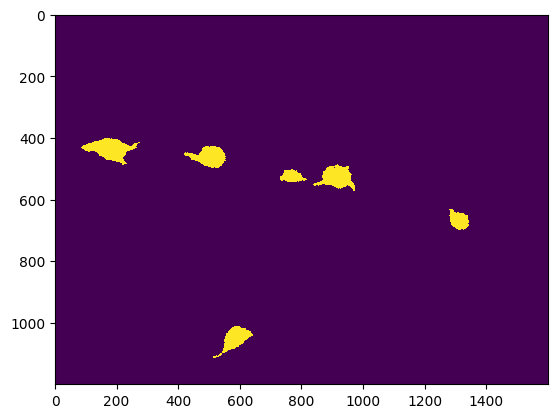

In [15]:
def answer_mask_preprocess(in_mask):
    uint8_image = cv.convertScaleAbs(in_mask)
    struct_element = cv.getStructuringElement(cv.MORPH_ELLIPSE, (2, 2))
    result_mask = cv.dilate(uint8_image, struct_element, iterations=2)
    return result_mask

image_processing.draw_plt_image(answer_mask_preprocess(test_masks[EXAMPLE_ID]))

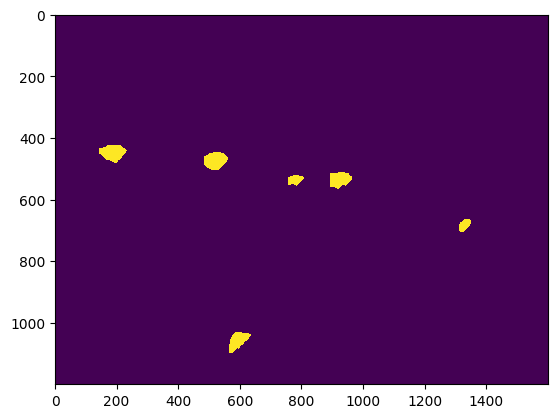

In [16]:
result_images = image_processing.process_images(train_pics, get_bin_component_image)

image_processing.draw_plt_image(result_images[EXAMPLE_ID])

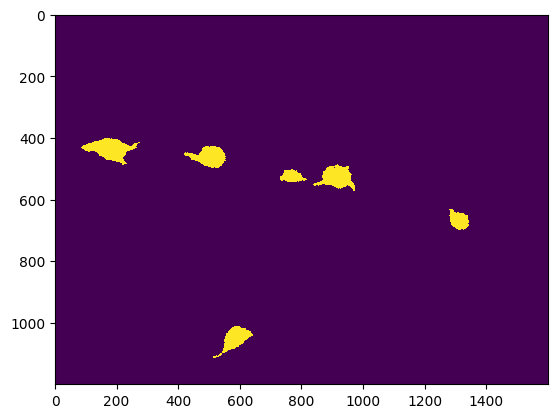

In [17]:
result_masks = image_processing.process_images(test_masks, answer_mask_preprocess)
image_processing.draw_plt_image(result_masks[EXAMPLE_ID])

Для каждого изображения вычислим число объектов на нем, сравним ответы от нашей и исходной маски:

In [18]:
def objects_count(image):
    components = cv.connectedComponents(image)
    return components[0] - 1

test_cmpts_count = image_processing.process_images(result_images, objects_count)
ref_cmpts_count = image_processing.process_images(result_masks, objects_count)

print(test_cmpts_count[EXAMPLE_ID], ref_cmpts_count[EXAMPLE_ID])

6 6


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   2.,   0.,   2.,   2.,   6.,   6.,   3.,   8.,  21.,
        128.,  43.,  18.,  18.,   9.,   5.,   4.,   1.,   0.,   2.,   2.,
          0.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([-28.   , -26.775, -25.55 , -24.325, -23.1  , -21.875, -20.65 ,
        -19.425, -18.2  , -16.975, -15.75 , -14.525, -13.3  , -12.075,
        -10.85 ,  -9.625,  -8.4  ,  -7.175,  -5.95 ,  -4.725,  -3.5  ,
         -2.275,  -1.05 ,   0.175,   1.4  ,   2.625,   3.85 ,   5.075,
          6.3  ,   7.525,   8.75 ,   9.975,  11.2  ,  12.425,  13.65 ,
         14.875,  16.1  ,  17.325,  18.55 ,  19.775,  21.   ]),
 <BarContainer object of 40 artists>)

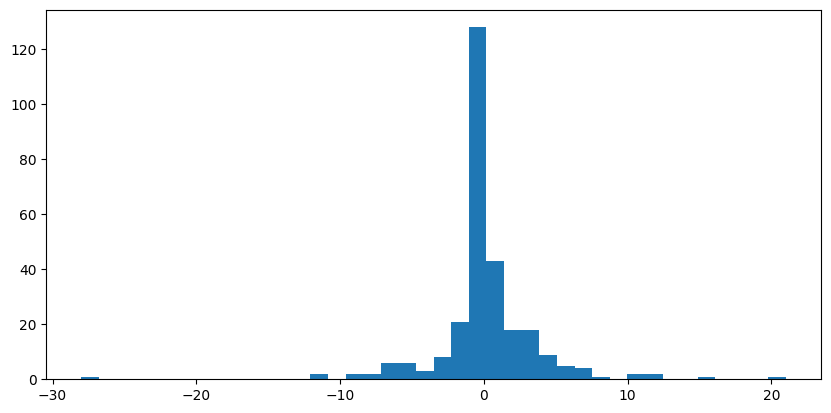

In [19]:
diff = test_cmpts_count - ref_cmpts_count

fig = plt.figure()
fig.set_figwidth(10)
plt.hist(diff, bins=40)